# Exploratory Analysis of Automatically Generated Text Corpus

In [1]:
# Imports
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.metrics.oov_words import OOVWords
from src.metrics.transrate import TransRate
from src.metrics.cosine_similarity import CosineSimilarity
from src.tools.text_processing import normalize_text
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer

import pandas as pd

from tqdm.notebook import tqdm, trange
tqdm.pandas()

import string

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from collections import Counter

import openai

from dotenv import load_dotenv, find_dotenv
import os

In [2]:
%pwd

'/mnt/rufus_A/multimemo/notebooks'

In [34]:
# Set up openai embedding model
# Get environment variables

load_dotenv(find_dotenv())

openai.api_type = "azure"
openai.api_key = os.environ.get('OPENAI_API_KEY')
openai.api_base = os.environ.get('OPENAI_API_BASE')
openai.api_version = os.environ.get('OPENAI_API_VERSION')

In [2]:
load_dotenv(find_dotenv())

openai.api_key = os.environ.get('OPENAI_API_KEY')

In [3]:
# Load data
data = pd.read_json('../data/processed/memento_data_recaption.json')
data_exp = data.explode(['captions', 'recaptions'], ignore_index=True)
print(f"Loaded {len(data_exp)} captions.")

Loaded 42500 captions.


In [4]:
# Remove punctuation

def remove_punctuation(text):
    """
    Remove punctuation from a text.
    """
    return text.translate(str.maketrans('', '', string.punctuation))

data_exp['captions'] = data_exp['captions'].apply(remove_punctuation)
data_exp['recaptions'] = data_exp['recaptions'].apply(remove_punctuation)


## OOV words

In [5]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
device = "cuda"

oov_metric = OOVWords(model, tokenizer, device)

In [6]:
data_exp['caption_oov_words'] = oov_metric.get_metric(data_exp['captions'].values, notebook=True)
print(f"Successfully computed OOV for {len(data_exp)} captions.")
print(f"Sample caption OOV: {data_exp['caption_oov_words'].values[:5]}")
data_exp['recaption_oov_words'] = oov_metric.get_metric(data_exp['recaptions'].values, notebook=True)
print(f"Successfully computed OOV for {len(data_exp)} recaptions.")
print(f"Sample recaption OOV: {data_exp['recaption_oov_words'].values[:5]}")

OOV words:   0%|          | 0/42500 [00:00<?, ?it/s]

OOV words: 100%|██████████| 42500/42500 [00:19<00:00, 2225.88it/s]


Successfully computed OOV for 42500 captions.
Sample caption OOV: [2 0 0 1 0]


OOV words: 100%|██████████| 42500/42500 [00:20<00:00, 2115.60it/s]

Successfully computed OOV for 42500 recaptions.
Sample recaption OOV: [0 1 1 1 1]


In [7]:
high_oov_captions = data_exp[data_exp['caption_oov_words'] > 0]
high_oov_captions[['captions', 'caption_oov_words']].head(10)

,captions,caption_oov_words
0,A brown hair girl with lip piercings mumbles s...,2
3,A young woman wearing a striped shirt who has ...,1
10,A person wearing a white sleeveless shirt is c...,1
11,A fat woman claps and hits the table while spe...,1
12,A larger woman in a white tank top claps her h...,1
14,A brunette sings and claps before in front of ...,1
20,Two overweight women sway next to each other a...,1
22,Two morbidly obese women dance and sing in a r...,2
24,two fatties stand around and sing while swayin...,1
36,The lower part of a womans face neck and shoul...,1


In [8]:
tokenizer.tokenize(high_oov_captions['captions'].iloc[6])

['two',
 'over',
 '##weight',
 'women',
 'sway',
 'next',
 'to',
 'each',
 'other',
 'as',
 'one',
 'of',
 'them',
 'sings']

In [9]:
no_oov = data_exp[data_exp['caption_oov_words'] == 0]
print(no_oov.shape)

(28780, 13)


In [10]:
# Percentage of OOV words in the captions and recaptions corpus
total_words_in_captions_corpus = 0
total_oov_words_in_captions_corpus = 0
total_words_in_recaptions_corpus = 0
total_oov_words_in_recaptions_corpus = 0
for _, row in tqdm(data_exp.iterrows(), total=data_exp.shape[0], desc="OOV words"):
    total_words_in_captions_corpus += len(row['captions'].split())
    total_words_in_recaptions_corpus += len(row['recaptions'].split())
    total_oov_words_in_captions_corpus += row['caption_oov_words']
    total_oov_words_in_recaptions_corpus += row['recaption_oov_words']
print(f"Percentage of OOV words in the captions corpus: {total_oov_words_in_captions_corpus/total_words_in_captions_corpus*100:.2f}%")
print(f"Percentage of OOV words in the recaptions corpus: {total_oov_words_in_recaptions_corpus/total_words_in_recaptions_corpus*100:.2f}%")


OOV words:   0%|          | 0/42500 [00:00<?, ?it/s]

Percentage of OOV words in the captions corpus: 2.98%
Percentage of OOV words in the recaptions corpus: 9.89%


In [11]:
data_exp[['caption_oov_words', 'recaption_oov_words']].describe()

,caption_oov_words,recaption_oov_words
count,42500.000000,42500.000000
mean,0.390165,1.338376
std,0.625585,1.152594
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,2.000000
max,6.000000,10.000000


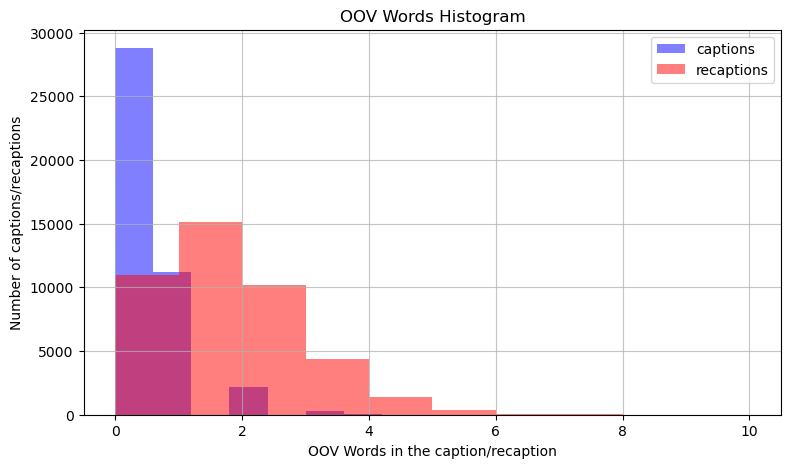

In [12]:
# Histogram of the OOV words for the captions and recaptions corpus (same plot)

plt.figure(figsize=(9, 5))
plt.hist(data_exp['caption_oov_words'], bins=10, alpha=0.5, label='captions', density=False, color='blue')
plt.hist(data_exp['recaption_oov_words'], bins=10, alpha=0.5, label='recaptions', density=False, color='red')
plt.legend(loc='upper right')
plt.grid(axis='both', alpha=0.75)
plt.xlabel('OOV Words in the caption/recaption')
plt.ylabel('Number of captions/recaptions')
plt.title('OOV Words Histogram')
plt.show()

In [13]:
data_exp['caption_length'] = data_exp['captions'].apply(lambda x: len(x.split()))
data_exp['caption_oov_words_ratio'] = data_exp['caption_oov_words'] / data_exp['caption_length']

data_exp['recaption_length'] = data_exp['recaptions'].apply(lambda x: len(x.split()))
data_exp['recaption_oov_words_ratio'] = data_exp['recaption_oov_words'] / data_exp['recaption_length']

data_exp[['caption_oov_words_ratio', 'recaption_oov_words_ratio']].describe()

,caption_oov_words_ratio,recaption_oov_words_ratio
count,42500.000000,42500.000000
mean,0.030617,0.103267
std,0.049828,0.090813
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.086957
75%,0.071429,0.153846
max,0.400000,0.800000


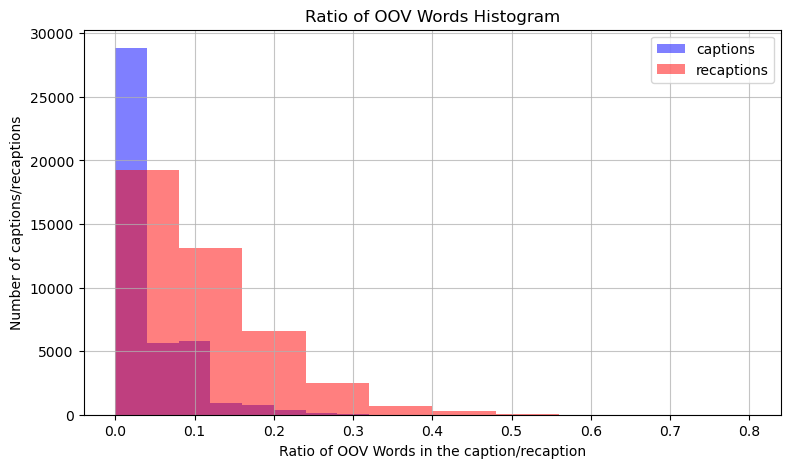

In [14]:
plt.figure(figsize=(9, 5))
plt.hist(data_exp['caption_oov_words_ratio'], bins=10, alpha=0.5, label='captions', density=False, color='blue')
plt.hist(data_exp['recaption_oov_words_ratio'], bins=10, alpha=0.5, label='recaptions', density=False, color='red')
plt.legend(loc='upper right')
plt.grid(axis='both', alpha=0.75)
plt.xlabel('Ratio of OOV Words in the caption/recaption')
plt.ylabel('Number of captions/recaptions')
plt.title('Ratio of OOV Words Histogram')
plt.show()

In [15]:
# Show recaptions examples with most OOV words
highest_oov_recaptions = data_exp[['recaptions','recaption_oov_words']].sort_values(by='recaption_oov_words', ascending=False).head(10)
highest_oov_recaptions

,recaptions,recaption_oov_words
25451,A wintry set of scenes filled with snowdriftin...,10
35244,A late night adventurer glides effortlessly up...,10
8329,A car winds its way through scorching sand dun...,9
35499,A group unwinds amidst the warmth of a burning...,9
39195,Un billet dune course nautique avec plusieurs ...,9
25359,A cute feline naps on a cozy beanbag then hila...,8
21264,Musicians donning cowboy hats grace the stage ...,8
9796,A tiny cherub nestled merrily within a comfy p...,8
36614,A school of shimmering fish glides amidst wave...,8
312,A tiny tot licks and slobbers over a toweldeck...,8


In [16]:
tokenizer.tokenize(highest_oov_recaptions['recaptions'].values[0])

['a',
 'win',
 '##try',
 'set',
 'of',
 'scenes',
 'filled',
 'with',
 'snow',
 '##dr',
 '##if',
 '##ting',
 'heavily',
 '##car',
 '##pet',
 '##ed',
 'cobb',
 '##led',
 'roads',
 'lit',
 'up',
 'by',
 'a',
 'charming',
 'collection',
 'of',
 'diverse',
 'residents',
 'o',
 '##cc',
 '##lus',
 '##ive',
 '##lo',
 '##oki',
 '##ng',
 'residences',
 'parallel',
 '##ed',
 'with',
 'ob',
 '##st',
 '##ru',
 '##cting',
 'driveway',
 '##s',
 'fence',
 '##d',
 'up',
 'by',
 'contrasting',
 'eccentric',
 'winter',
 '##cha',
 '##rio',
 '##t',
 'bars',
 'surrounded']

In [17]:
# Create a dicttionary that stores the number of times each OOV word appears in the captions
oov_words_captions = Counter()
for _,row in tqdm(data_exp.iterrows(), total=len(data_exp)):
    for word in row['captions'].split():
        if oov_metric.is_oov(word):
            oov_words_captions[word] += 1

print("Number of OOV words in captions: ", len(oov_words_captions))
# Print most frequent
print(oov_words_captions.most_common(10))

  0%|          | 0/42500 [00:00<?, ?it/s]

Number of OOV words in captions:  4196
[('toddler', 457), ('swims', 236), ('skis', 198), ('pans', 174), ('surfboard', 147), ('crawls', 126), ('skateboard', 116), ('bib', 111), ('bathtub', 110), ('onlookers', 108)]


In [18]:
# Get the tokens for the 10 most common OOV words in the captions in a dictionary
oov_words = oov_words_captions.most_common(20)
oov_tokens = {}
for oov_word, _ in tqdm(oov_words):
    tokens = tokenizer.tokenize(oov_word)
    if len(tokens) > 1:
        tokens = [token for token in tokens if token not in ['[UNK]', '[PAD]']]
    if len(tokens) > 0:
        oov_tokens[oov_word] = tokens
oov_tokens

  0%|          | 0/20 [00:00<?, ?it/s]

{'toddler': ['todd', '##ler'],
 'swims': ['swim', '##s'],
 'skis': ['ski', '##s'],
 'pans': ['pan', '##s'],
 'surfboard': ['surf', '##board'],
 'crawls': ['crawl', '##s'],
 'skateboard': ['skate', '##board'],
 'bib': ['bi', '##b'],
 'bathtub': ['bath', '##tub'],
 'onlookers': ['on', '##lo', '##oke', '##rs'],
 'skates': ['skate', '##s'],
 'claps': ['clap', '##s'],
 'crib': ['cr', '##ib'],
 'trampoline': ['tram', '##pol', '##ine'],
 'kayak': ['kay', '##ak'],
 'bikers': ['biker', '##s'],
 'cheerleaders': ['cheer', '##leader', '##s'],
 'someones': ['someone', '##s'],
 'bounces': ['bounce', '##s'],
 'chews': ['chew', '##s']}

In [19]:
# Create a dicttionary that stores the number of times each OOV word appears in the recaptions
oov_words_recaptions = Counter()
for _,row in tqdm(data_exp.iterrows(), total=len(data_exp)):
    for word in row['recaptions'].split():
        if oov_metric.is_oov(word):
            oov_words_recaptions[word] += 1

print("Number of OOV words in captions: ", len(oov_words_recaptions))
# Print most frequent
print(oov_words_recaptions.most_common(10))

  0%|          | 0/42500 [00:00<?, ?it/s]

Number of OOV words in captions:  11274
[('glides', 913), ('joyfully', 830), ('navigates', 744), ('toddler', 621), ('bustling', 522), ('energetically', 447), ('feline', 415), ('joyful', 354), ('onlookers', 310), ('donning', 290)]


In [20]:
# Get the tokens for the 10 most common OOV words in the captions in a dictionary
oov_words_re = oov_words_recaptions.most_common(20)
oov_tokens_re = {}
for oov_word, _ in tqdm(oov_words_re):
    tokens = tokenizer.tokenize(oov_word)
    if len(tokens) > 1:
        tokens = [token for token in tokens if token not in ['[UNK]', '[PAD]']]
    if len(tokens) > 0:
        oov_tokens_re[oov_word] = tokens
oov_tokens_re

  0%|          | 0/20 [00:00<?, ?it/s]

{'glides': ['glide', '##s'],
 'joyfully': ['joy', '##fully'],
 'navigates': ['navigate', '##s'],
 'toddler': ['todd', '##ler'],
 'bustling': ['bust', '##ling'],
 'energetically': ['energetic', '##ally'],
 'feline': ['fe', '##line'],
 'joyful': ['joy', '##ful'],
 'onlookers': ['on', '##lo', '##oke', '##rs'],
 'donning': ['don', '##ning'],
 'mesmerizing': ['me', '##sm', '##eri', '##zing'],
 'leisurely': ['leisure', '##ly'],
 'navigating': ['na', '##vi', '##gating'],
 'skillfully': ['skill', '##fully'],
 'interacts': ['interact', '##s'],
 'captivating': ['capt', '##ivating'],
 'cascading': ['cas', '##ca', '##ding'],
 'youngster': ['young', '##ster'],
 'festive': ['fest', '##ive'],
 'tranquil': ['tran', '##quil']}

In [22]:
# Get the recaptions with most OOV words and compute cosine similarity to the original caption

cosine_sim_metric = CosineSimilarity(model, tokenizer, device)

for _,row in data_exp.sort_values(by='caption_oov_words', ascending=False).head(10).iterrows():
    print(f"Original caption: {row['captions']}")
    print(f"Recaption: {row['recaptions']}")
    print(f"Cosine similarity: {cosine_sim_metric.get_metric([row['captions']], [row['recaptions']])[0][0]}")
    print()

Original caption: A yellowed headed parakeet with an olive greengrey body is chirping up past wooden poles on a stoop while orange plastic chains hang in the foreground
Recaption: A colorful bird perches and creates sounds amongst tall wooden poles and bright orange chains in the foreground
Cosine similarity: 0.6839526891708374

Original caption: Yellow Iguana is eating crickets out of a bowel with crickets and strawberries
Recaption: A vibrant Iguana savors snacks from a bowled banquet of crickets and strawberries
Cosine similarity: 0.7721712589263916

Original caption: A beagle licks a golden retriever on the body while The golden retriever wags his tail
Recaption: A friendly beagle loves to groom a cheerful golden retriever by licking its fur and making it wag its happy tail
Cosine similarity: 0.7730629444122314

Original caption: A doctor and a nurse adjust and stead a squirming baby thats inside an incubator inside an ICU
Recaption: Two medical professionals working together to ca

In [23]:
cosine_sim_metric.get_metric("This is a test", "This is another test")

array([[0.90610707]], dtype=float32)

In [24]:
cosine_sim_metric_openai = CosineSimilarity("text-embedding-ada-002", tokenizer, device)

for _,row in data_exp.sort_values(by='caption_oov_words', ascending=False).head(10).iterrows():
    print(f"Original caption: {row['captions']}")
    print(f"Recaption: {row['recaptions']}")
    print(f"Cosine similarity: {cosine_sim_metric_openai.get_metric([row['captions']], [row['recaptions']])[0][0]}")
    print()

Original caption: A yellowed headed parakeet with an olive greengrey body is chirping up past wooden poles on a stoop while orange plastic chains hang in the foreground
Recaption: A colorful bird perches and creates sounds amongst tall wooden poles and bright orange chains in the foreground
Using the first text in the list.
Using the first text in the list.
Cosine similarity: 0.9351926551293945

Original caption: Yellow Iguana is eating crickets out of a bowel with crickets and strawberries
Recaption: A vibrant Iguana savors snacks from a bowled banquet of crickets and strawberries
Using the first text in the list.
Using the first text in the list.
Cosine similarity: 0.9604398787825085

Original caption: A beagle licks a golden retriever on the body while The golden retriever wags his tail
Recaption: A friendly beagle loves to groom a cheerful golden retriever by licking its fur and making it wag its happy tail
Using the first text in the list.
Using the first text in the list.
Cosine 

In [25]:
df = data_exp.sort_values(by='caption_oov_words', ascending=False).head(100)
df['cosine_sim_mpnet'] = df.progress_apply(lambda row: cosine_sim_metric.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)
df['cosine_sim_openai'] = df.progress_apply(lambda row: cosine_sim_metric_openai.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)

df

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,filename,url,mem_score,alpha,audio_description,captions,action_labels,actions,responses,recaptions,total_used_tokens,caption_oov_words,recaption_oov_words,caption_length,caption_oov_words_ratio,recaption_length,recaption_oov_words_ratio,cosine_sim_mpnet,cosine_sim_openai
34688,whistling_flickr-4-1-4-3-0-7-4-5-4541430745_74...,https://data.csail.mit.edu/soundnet/actions3/w...,0.859782,-0.001601,a parakeet with a yellow head and orange spot ...,A yellowed headed parakeet with an olive green...,"[whistling, sing, blowing, standing]","whistling, sing, blowing, standing",[{'id': 'chatcmpl-7KEsD8XHCFgWtwz2j23yy9Lqsprh...,A colorful bird perches and creates sounds amo...,1898,6,2,26,0.230769,18,0.111111,0.683953,0.935193
9070,eating_flickr-4-0-0-2-8-6-9-6-3140028696_6.mp4,https://data.csail.mit.edu/soundnet/actions3/e...,0.956170,-0.000442,we have what looks like a bearded dragon havin...,Yellow Iguana is eating crickets out of a bowe...,"[eating, sitting, attacking, feeding]","eating, sitting, attacking, feeding",[{'id': 'chatcmpl-7JsfxqHcgQm6WSgGRX7Wh5N49Irr...,A vibrant Iguana savors snacks from a bowled b...,1875,5,4,13,0.384615,13,0.307692,0.772171,0.960467
37995,licking_flickr-5-4-1-5-0-9-8-6-2554150986_83.mp4,https://data.csail.mit.edu/soundnet/actions3/l...,0.882156,-0.001528,on a wooden floor there are two small brown do...,A beagle licks a golden retriever on the body ...,"[licking, eating, washing, imitating, cleaning]","licking, eating, washing, imitating, cleaning",[{'id': 'chatcmpl-7KINpiV79VbEGlRLLnZsvfWo6TX9...,A friendly beagle loves to groom a cheerful go...,1880,5,3,16,0.312500,21,0.142857,0.773063,0.963662
7209,discussing_0-9-8-2-2-0-2-4-2509822024.mp4,https://data.csail.mit.edu/soundnet/actions3/d...,0.803126,-0.000455,in this video she possibly a new dad and a nur...,A doctor and a nurse adjust and stead a squirm...,[performing],performing,[{'id': 'chatcmpl-7Jr4hlVGcMK68hWzqIBlqh8o4LWC...,Two medical professionals working together to ...,1871,5,0,18,0.277778,21,0.000000,0.703262,0.907246
30119,talking_0-1-0-8-1-3-7-1-2701081371.mp4,https://data.csail.mit.edu/soundnet/actions3/t...,0.820418,-0.001956,someone is filming objects in their home a car...,a camera pans a room and shows a carlsberg bee...,"[sitting, filming, speaking]","sitting, filming, speaking",[{'id': 'chatcmpl-7KBp3szwndg2WPQ1lCijvt8557HH...,A video captures a room with a Carlsberg beer ...,1878,5,3,24,0.208333,18,0.166667,0.866015,0.972604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25077,slipping_2-1-8-5332948218.mp4,https://data.csail.mit.edu/soundnet/actions3/s...,0.639985,-0.000093,people are on snowboards on a mountain slope a...,There are various skiers and snowboarders on t...,"[slipping, skating, skiing, seeming]","slipping, skating, skiing, seeming",[{'id': 'chatcmpl-7K9ezYwILCvcluHWz3exj6XwODru...,Several winter sports enthusiasts glide and gr...,1871,3,1,12,0.250000,13,0.076923,0.664756,0.919034
12184,hiking_flickr-7-7-1-4-2-8-3-6-15777142836_9.mp4,https://data.csail.mit.edu/soundnet/actions3/h...,0.884792,-0.002100,outdoors we see a man dress for cold wearing s...,The man in the beanie and coat pans his selfie...,"[showing, rotating]","showing, rotating",[{'id': 'chatcmpl-7Jy54LtqpjDIA1fl5mokqQQOsgLs...,A beanieclad man pivots his front camera to re...,1838,3,2,15,0.200000,11,0.181818,0.641285,0.943491
28825,surfing_flickr-0-7-0-5-8-4-5-1-4807058451_1.mp4,https://data.csail.mit.edu/soundnet/actions3/s...,0.754383,-0.002280,this video shows someone trying to surf in the...,a man paddles a surfboard and catches a small ...,"[surfing, splashing, showing, flowing]","surfing, splashing, showing, flowing",[{'id': 'chatcmpl-7KBXjdYDavSGNXebmDPzVWvpR1Uz...,A surfer conquers the rough waters on his board,1875,3,1,11,0.272727,9,0.111111,0.545162,0.910957
37474,grilling_flickr-2-4-9-3-6-1-9-4-14024936194_35...,https://data.csail.mit.edu/soundnet/actions3/g...,0.934460,-0.000100,there is an assortment of food a

In [26]:
# Edit pandas display options so that we can see the full text
pd.set_option('display.max_colwidth', None)
df[['captions','recaptions','caption_oov_words','cosine_sim_mpnet','cosine_sim_openai']].head(5)

,captions,recaptions,caption_oov_words,cosine_sim_mpnet,cosine_sim_openai
34688,A yellowed headed parakeet with an olive greengrey body is chirping up past wooden poles on a stoop while orange plastic chains hang in the foreground,A colorful bird perches and creates sounds amongst tall wooden poles and bright orange chains in the foreground,6,0.683953,0.935193
9070,Yellow Iguana is eating crickets out of a bowel with crickets and strawberries,A vibrant Iguana savors snacks from a bowled banquet of crickets and strawberries,5,0.772171,0.960467
37995,A beagle licks a golden retriever on the body while The golden retriever wags his tail,A friendly beagle loves to groom a cheerful golden retriever by licking its fur and making it wag its happy tail,5,0.773063,0.963662
7209,A doctor and a nurse adjust and stead a squirming baby thats inside an incubator inside an ICU,Two medical professionals working together to care for a fragile baby in need of attention and assistance within a specialized unit,5,0.703262,0.907246
30119,a camera pans a room and shows a carlsberg beer inflatable and then zooms to a tv screen on top of a credenza bureau,A video captures a room with a Carlsberg beer inflatable and a TV screen atop a credenza bureau,5,0.866015,0.972604


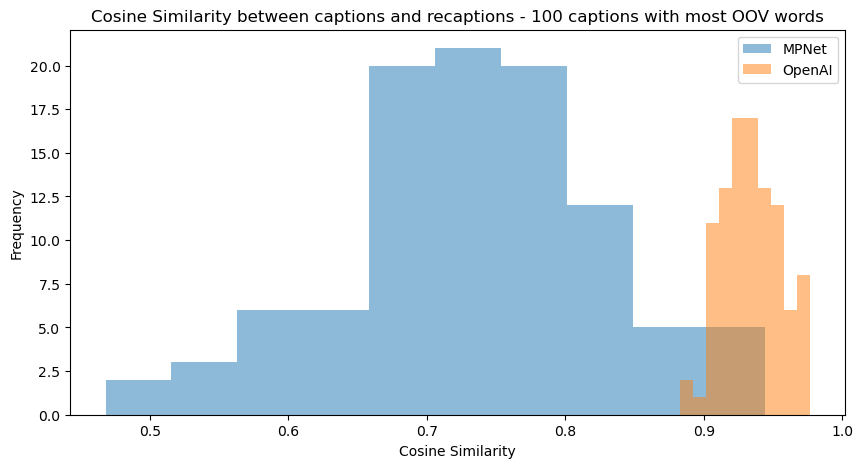

In [27]:
# Plot an overimposed histogram of the cosine similarities per MPNet and OpenAI
plt.figure(figsize=(10, 5))
plt.hist(df['cosine_sim_mpnet'], bins=10, alpha=0.5, label='MPNet')
plt.hist(df['cosine_sim_openai'], bins=10, alpha=0.5, label='OpenAI')
plt.legend(loc='upper right')
plt.title('Cosine Similarity between captions and recaptions - 100 captions with most OOV words')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [29]:
df2 = data_exp.sort_values(by='recaption_oov_words', ascending=False).head(100)
df2['cosine_sim_mpnet'] = df2.progress_apply(lambda row: cosine_sim_metric.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)
df2['cosine_sim_openai'] = df2.progress_apply(lambda row: cosine_sim_metric_openai.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)

df2[['captions','recaptions','caption_oov_words','cosine_sim_mpnet','cosine_sim_openai']].head(5)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

,captions,recaptions,caption_oov_words,cosine_sim_mpnet,cosine_sim_openai
25451,Snow covered houses on a snow covered street with snow blanketed cars,A wintry set of scenes filled with snowdrifting heavilycarpeted cobbled roads lit up by a charming collection of diverse residents occlusivelooking residences paralleled with obstructing driveways fenced up by contrasting eccentric winterchariot bars surrounded,1,0.711434,0.907137
35244,a man wearing a backpack snowboards up a hill at night,A late night adventurer glides effortlessly up a snowcapped mound adorned in frontporch America cos omcmene up omypist opws7 codingdeEra eraKr eujsloopaw,1,0.460499,0.861020
8329,The view outside the windshield of a vehicle as it drives through a desert,A car winds its way through scorching sand dunes trudging through them under an sunpuzzling earth bleached without any discernible peak insight into the neverending expanses of the world also barrennes canyd sculptures watching them,0,0.566428,0.888759
35499,People are sitting around a campfire and the lady in a green sweatshirt is roasting marshmallows,A group unwinds amidst the warmth of a burning evening fire pit where a lady adorns a green sweatshirt and frosts foamy marshmallows over the brilliantly undulating and twinkling ember lights,3,0.796249,0.935788
39195,Several teams of four people each rowing down a waterway,Un billet dune course nautique avec plusieurs équipes de quatre pagayeurs glissant sur une voie navigable,0,0.276925,0.869016


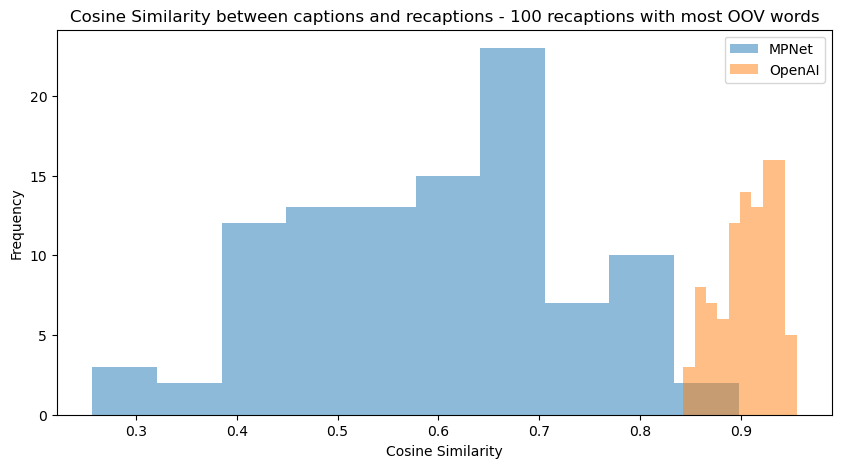

In [30]:
# Plot an overimposed histogram of the cosine similarities per MPNet and OpenAI
plt.figure(figsize=(10, 5))
plt.hist(df2['cosine_sim_mpnet'], bins=10, alpha=0.5, label='MPNet')
plt.hist(df2['cosine_sim_openai'], bins=10, alpha=0.5, label='OpenAI')
plt.legend(loc='upper right')
plt.title('Cosine Similarity between captions and recaptions - 100 recaptions with most OOV words')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [33]:
df3 = data_exp.sample(5000, random_state=42)
df3['cosine_sim_mpnet'] = df3.progress_apply(lambda row: cosine_sim_metric.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)
df3['cosine_sim_openai'] = df3.progress_apply(lambda row: cosine_sim_metric_openai.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)

df3[['captions','recaptions','caption_oov_words','cosine_sim_mpnet','cosine_sim_openai']].head(5)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

,captions,recaptions,caption_oov_words,cosine_sim_mpnet,cosine_sim_openai
36506,A blow fish swims along some coral reefs in an aquarium,A puffedup fish explores vibrant coral in an underwater room with clear walls,1,0.734054,0.927767
2265,There is something on fire on what appears to be a dark night,A bright blaze illuminates the darkness of an obscure night,0,0.690853,0.932103
30324,A dog walking around in grass next to a large pile of sticks,A canine strolls through a lush lawn alongside heaps of wood debris nearby,0,0.712160,0.940940
7481,A fish is swimming under water where the floor is littered with coral,A colorful fish explores an underwater world full of vibrant coral,0,0.702900,0.934687
30545,A baby smiles at the camera while wrapped in a white cloth,An adorable infant joyfully gazes at the camera swaddled in pristine fabric,0,0.818118,0.950467


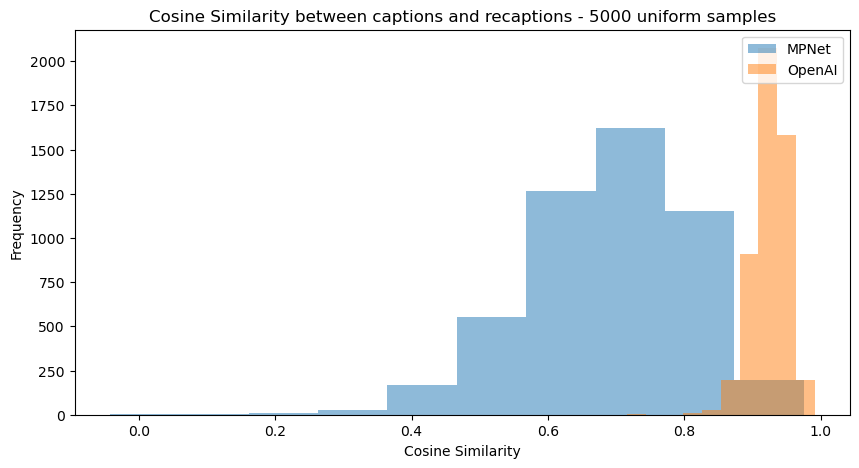

In [34]:
# Plot an overimposed histogram of the cosine similarities per MPNet and OpenAI
plt.figure(figsize=(10, 5))
plt.hist(df3['cosine_sim_mpnet'], bins=10, alpha=0.5, label='MPNet')
plt.hist(df3['cosine_sim_openai'], bins=10, alpha=0.5, label='OpenAI')
plt.legend(loc='upper right')
plt.title('Cosine Similarity between captions and recaptions - 5000 uniform samples')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
data_exp['cosine_sim_mpnet'] = data_exp.progress_apply(lambda row: cosine_sim_metric.get_metric(row['recaptions'], row['captions'])[0][0], axis=1)

In [44]:
data_exp['cosine_sim_mpnet'].describe()

count    42500.000000
mean         0.692201
std          0.120035
min         -0.049704
25%          0.618009
50%          0.703642
75%          0.779243
max          0.975266
Name: cosine_sim_mpnet, dtype: float64

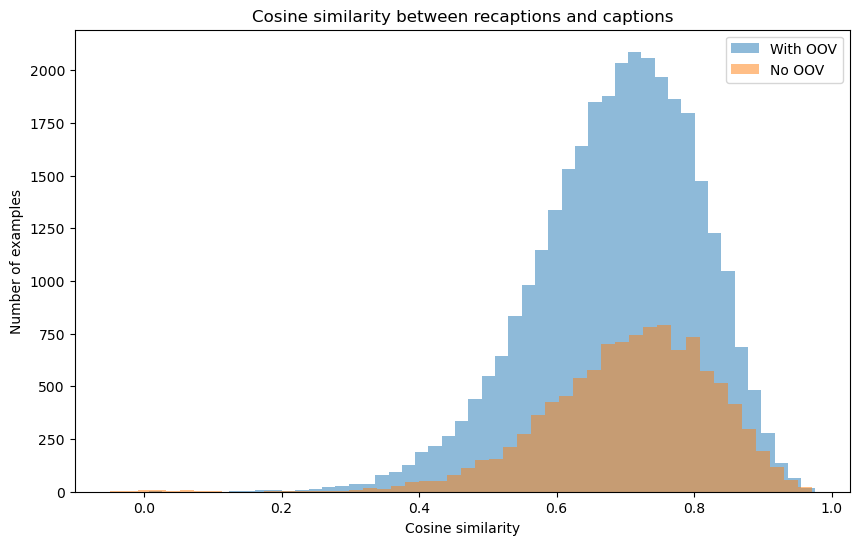

In [39]:
plt.figure(figsize=(10, 6))
# Histogram of cosine similarities for recaptions with no oov words
plt.hist(data_exp[data_exp['recaption_oov_words']>0]['cosine_sim_mpnet'], bins=50, alpha=0.5, label='With OOV')
plt.hist(data_exp[data_exp['recaption_oov_words']==0]['cosine_sim_mpnet'], bins=50, alpha=0.5, label='No OOV')
plt.legend(loc='upper right')
plt.title('Cosine similarity between recaptions and captions')
plt.xlabel('Cosine similarity')
plt.ylabel('Number of examples')
plt.show()

In [48]:
# Mean and std cosine similarity between caption and recaption with respect to number of OOV words

cosine_sim_vs_oov_df = pd.DataFrame(columns=['oov', 'mean', 'std'])
for oov in trange(0, data_exp['recaption_oov_words'].max() + 1):
    cosine_sim_vs_oov_df = pd.concat([cosine_sim_vs_oov_df, pd.DataFrame({
        'oov': oov,
        'mean': data_exp[data_exp['recaption_oov_words'] == oov]['cosine_sim_mpnet'].mean(),
        'std': data_exp[data_exp['recaption_oov_words'] == oov]['cosine_sim_mpnet'].std()
    }, index=[0])], ignore_index=True)

cosine_sim_vs_oov_df


  0%|          | 0/11 [00:00<?, ?it/s]

,oov,mean,std
0,0,0.704962,0.123412
1,1,0.698832,0.116565
2,2,0.685377,0.117068
3,3,0.671316,0.120734
4,4,0.658099,0.121551
5,5,0.639237,0.122610
6,6,0.609922,0.136014
7,7,0.592627,0.144047
8,8,0.601037,0.134286
9,9,0.546534,0.260233


In [59]:
# Lineplot of the mean cosine similarity vs number of OOV words with std as error bars
# The mean should be a lineplot, and the error should be represented as lines with a different color
# The space between must be shaded
# Use plotly

fig = px.line(
    x=cosine_sim_vs_oov_df["oov"],
    y=cosine_sim_vs_oov_df["mean"],
    title="Cosine Similarity vs Number of OOV Words",
    # error_y=cosine_sim_vs_oov_df["std"],
    labels={
        "x": "Number of OOV Words",
        "y": "Cosine Similarity",
        "error_y": "Standard Deviation",
    },
)

fig.update_traces(
    line=dict(color="blue"),
    error_y=dict(
        type="data",
        symmetric=False,
        array=cosine_sim_vs_oov_df["mean"] + cosine_sim_vs_oov_df["std"],
        arrayminus=cosine_sim_vs_oov_df["mean"] - cosine_sim_vs_oov_df["std"],
        thickness=1.5,
        width=3,
        color="blue",
    ),
)

fig.show()


